In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install imutils
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import imutils
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model


RANDOM_SEED = 123

In [ ]:
def crop_brain_contour(image, plot=False):

    '''# image as input
     # performs various image processing operations to crop the brain and contour from the image
    
    #cvtColor -> change one color image to another, the purpose of blurring is to reduce noise and smoother the image'''
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)                       # in this gaussian blur we apply the standar deviation of X and Y directions
    # Gaussian Noise is a statistical noise having a probability density function equal to normal distribution, also known as Gaussian Distribution.

    '''
    # Blurred grayscale image -> binary thershold operation
    # image -> binary image(45)-255(white),0(black)
    '''
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    # For every pixel, the same threshold value is applied. If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value.
    #The function cv.threshold is used to apply the thresholding.
    #The first argument is the source image, which should be a grayscale image.
    #The second argument is the threshold value which is used to classify the pixel values.
    #The third argument is the maximum value which is assigned to pixel values exceeding the threshold.

"""
    # erode - destroy
    # Morphological Operation
    # erode away the boundaries of foreground objects
    # Remove small noise regions and refine the shape of the brain contour
    """

    thresh = cv2.erode(thresh, None, iterations=2)
    #cv2.erode() method is used to perform erosion on the image.
    #The basic idea of erosion is just like soil erosion only, it erodes away the boundaries of foreground object.
    #It is normally performed on binary images. It needs two inputs, one is our original image, second one is called structuring element or kernel which decides the nature of operation. A pixel in the original image (either 1 or 0) will be considered 1 only if all the pixels under the kernel is 1, otherwise it is eroded (made to zero).
    thresh = cv2.dilate(thresh, None, iterations=2)
    #This operation is the sister of dilation. It computes a local minimum over the area of given kernel.

   '''
    # dilate - expand
    # Morphological Operation
    # expands the boundaries of foreground objects
    # restore the size and shape of the brain contour 
    '''

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    '''
    # ReTR - retrievel
    # CHAIN_APPROX_SIMPLE - aprox method compress the contour information by only storing endpoints
    '''

    cnts = imutils.grab_contours(cnts)
    '''
    calculate the area of a contour
    '''
    c = max(cnts, key=cv2.contourArea)
    cv2.drawContours(image, cnts, -1, (0, 0, 255), 2)

    # extreme points- defines a bounding box around the brain
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        '''
        subplot(1, 2, 1) - row=1,column=2,index=1
        '''
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
         '''
        subplot(1, 2, 2) - row=1,column=2,index=2
        '''
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
        cv2_imshow(image)

    return new_image


In [ ]:
def load_data(dir_list, image_size):
'''
  loads image from directories, Preprocess them and
   return the preprocessed image as well as corresponding lablels

initialize list empty   x=image, y=label

'''
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    i=0
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            # only for plotting single preprocessed brain image image
            if (i==0):
              image = crop_brain_contour(image, plot=True)
              i=i+1
            else:
              image = crop_brain_contour(image, plot=False)

            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            #If you are enlarging the image, you should prefer to use INTER_LINEAR or INTER_CUBIC interpolation.
            #For shrinking the image, INTER_AREA interpolation.
            #Cubic interpolation is computationally more complex, and hence slower than linear interpolation.
            #However, the quality of the resulting image will be higher.
'''
           # normalize the pixel values 
           commonly used in image processing task
           '''
            # normalize values
            image = image / 255.

            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
 '''
      converzts the  x and y lists into numpy array
      '''   
    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

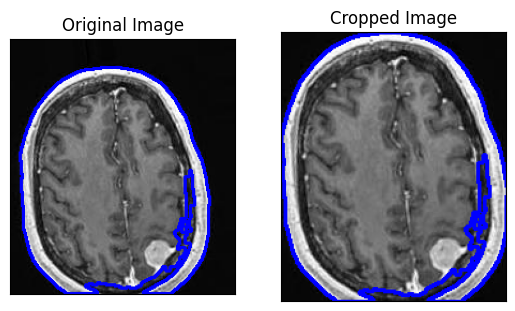

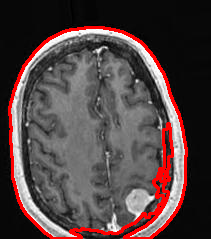

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


In [ ]:
augmented_data_path='/content/drive/MyDrive/augmented data/'
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))


In [ ]:
def plot_sample_images(X, y, n=40):
     '''
  #preprocessed image (x), their corresponding labels(y) and no.of image plot(n)
  #functions plot a sample of image from each class (0 and 1) to visualize the data
  
  
  # iterates over each labels (0 and 1)
  select image from x that have the corresponding label equal to the current label in loop

  argwhere -> to find the indicies where y is equal to the label and then uses these indices to select the corresponding images from x
  n_images = images[:n] -> selects 1st image n image from the selected image for the current label. Ensure that only a subset of image is plotted
  '''
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
''' tick_params -> disables the thick marks'''
            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()


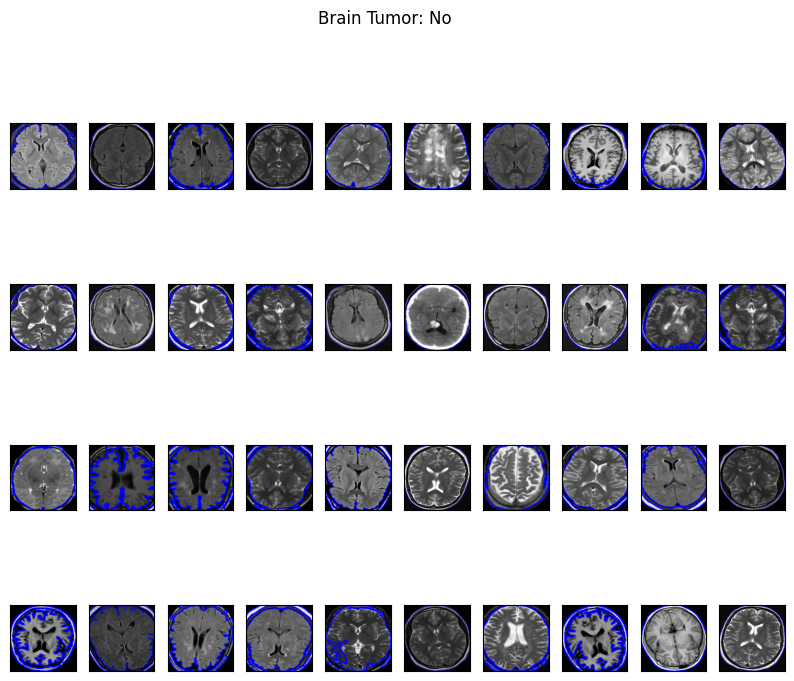

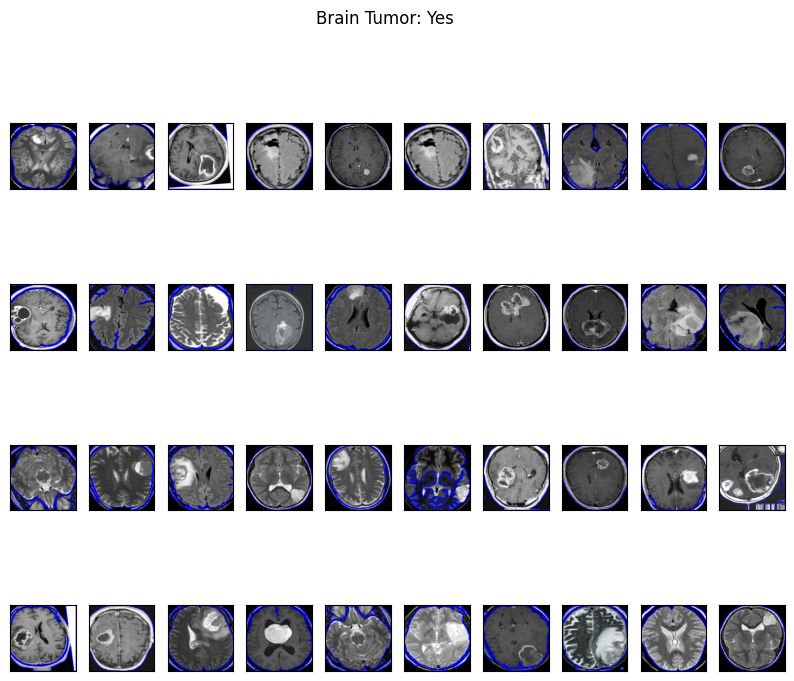

In [ ]:
plot_sample_images(X, y)

In [ ]:
def split_data(X, y, test_size=0.2):
'''
        split_data into 
       training (model learns from the data) , 
       validation (fine tune the model and make decision. Maintaing models performance during traing and preventing overfitting), 
       testing (evaluates the performance of the training model)


       80% training and validation 
       '''
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.8)

    return X_train, y_train, X_val, y_val, X_test, y_test


In [ ]:
'''
20% testing 
'''
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.2)

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))


number of training examples = 1652
number of validation examples = 331
number of test examples = 82


In [ ]:
def build_model(input_shape):
    # constructs CNN for binary classification
    X_input = Input(input_shape)
    #ZeroPadding2D -> helps preserve spatial dimension during convolutional operation
    X = ZeroPadding2D((2, 2))(X_input)
    # add layer with 32 filter, size 7*7
    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    # stablize the training process and improves the model's performance
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    # apply relu (rectified linear unit), to introduce non-linearity to the network
    X = Activation('relu')(X)
    
    # downsample the feature map and extract the most important feature
    X = MaxPooling2D((4, 4))(X)
    X = MaxPooling2D((4, 4))(X)
    # Flattens the 2D feature map into a 1D vector preprocesing them for the fully connected layer
    X = Flatten()(X)
    # sigmoid -> suitable for binary classification task others are like Tanh, ReLU, Leaky ReLU, Softman
    X = Dense(1, activation='sigmoid')(X)

    model = Model(inputs = X_input, outputs = X)

    return model


In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)  # 3 -> RGB color channel
model=build_model(IMG_SHAPE)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                           

In [ ]:
'''
optimizer='adam' -> maintain seperate learning rate for different modl parmeter, and adapt based on the average of the past gradient
                -> Robustness AND fast convergene
                -> others are descent, RMSprop, AdaGrad, Adadelta

loss='binary_crossentropy' -> measure dissimilarity between predicted probablities and true binary labels
                           -> BCE = -(y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred))
                           -> others are Mean Squared Error (MSE), Categorical Cross-Entropy Loss, Hinge Loss, Kullback-Leibler Divergence
'''
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))
model.save("Brain_tumor_detection.h5")


Epoch 1/22
52/52 [==============================] - 144s 3s/step - loss: 0.8473 - accuracy: 0.6235 - val_loss: 0.6833 - val_accuracy: 0.5196
Epoch 2/22
52/52 [==============================] - 167s 3s/step - loss: 0.4672 - accuracy: 0.7766 - val_loss: 0.6082 - val_accuracy: 0.6616
Epoch 3/22
52/52 [==============================] - 139s 3s/step - loss: 0.3679 - accuracy: 0.8450 - val_loss: 0.4817 - val_accuracy: 0.8580
Epoch 4/22
52/52 [==============================] - 138s 3s/step - loss: 0.3144 - accuracy: 0.8680 - val_loss: 0.4280 - val_accuracy: 0.8520
Epoch 5/22
52/52 [==============================] - 137s 3s/step - loss: 0.2620 - accuracy: 0.8959 - val_loss: 0.5809 - val_accuracy: 0.6526
Epoch 6/22
52/52 [==============================] - 137s 3s/step - loss: 0.2445 - accuracy: 0.9038 - val_loss: 0.3383 - val_accuracy: 0.8792
Epoch 7/22
52/52 [==============================] - 142s 3s/step - loss: 0.2091 - accuracy: 0.9165 - val_loss: 0.3817 - val_accuracy: 0.8399
Epoch 8/22
52

In [ ]:
# Stores and access training history 
history = model.history.history

In [ ]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

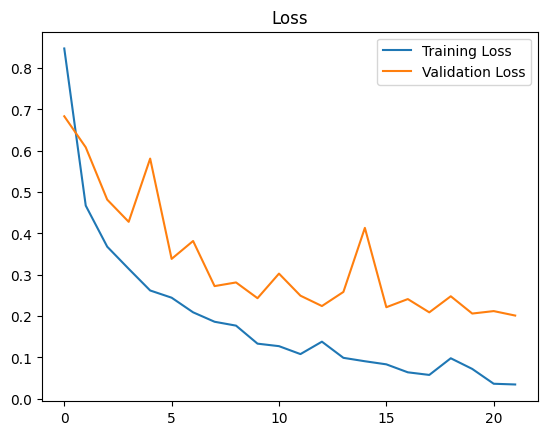

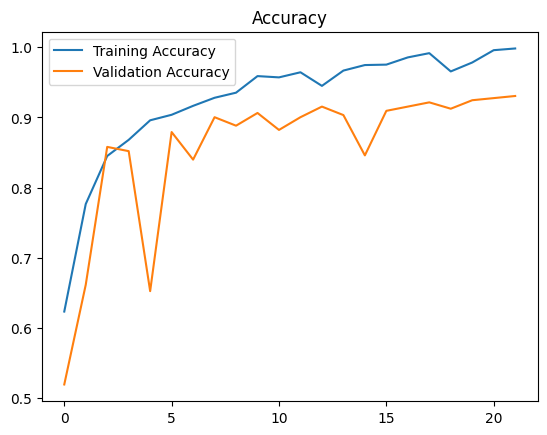

In [ ]:
plot_metrics(history)

In [ ]:
!pip install --upgrade scikit-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


11/11 [==============================] - 7s 675ms/step
Val Accuracy = 0.93
Confusion Matrix:
[[135   7]
 [ 16 173]]


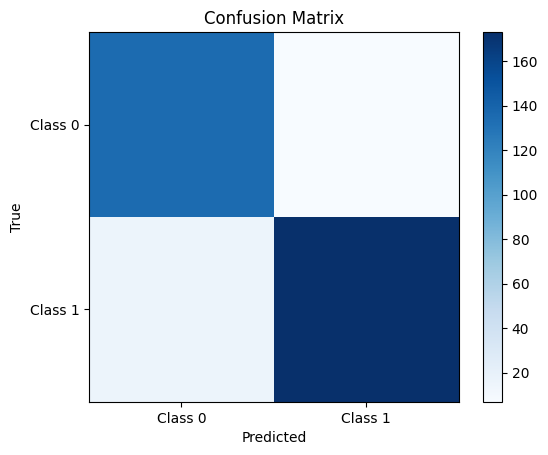

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

predictions = model.predict(X_val)
predictions = [1 if x > 0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

cm = confusion_matrix(y_val, predictions)
print('Confusion Matrix:')
print(cm)

# Visualize confusion matrix
'''
interpolation -> generate smooth curves that aprox the underlying relationship b/w the existing data point
              -> resize or rescale

interpolation='nearest'  -> Computaionally efficitvely but can result in pixelation and loss of image details
                         -> others are bilinear, biscubic, hanczos
'''

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.yticks([0, 1], ['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# validate on test set
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]
accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

3/3 [==============================] - 2s 507ms/step
Test Accuracy = 0.90


In [ ]:
# validate on test set
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]
accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

3/3 [==============================] - 2s 461ms/step
Test Accuracy = 0.90


In [ ]:
from keras.models import load_model
tumor_model = load_model('/content/Brain_tumor_detection.h5')
#acc = tumor_model.evaluate(X_test,y_test)


In [ ]:
import cv2
import numpy as np

test_img = cv2.imread('/content/drive/MyDrive/no/12 no.jpg')

if test_img is None:
    print('Error: Failed to load the image file')
else:
    test_img = cv2.resize(test_img, (240, 240))
    test_img = np.expand_dims(test_img, axis=0)
    print('Image shape:', test_img.shape)


Image shape: (1, 240, 240, 3)


In [ ]:
test_pred = tumor_model.predict(test_img)
test_pred


1/1 [==============================] - 0s 146ms/step


array([[0.]], dtype=float32)

In [ ]:
if (test_pred[0,0]==1):
  print("Tumor Found")
else:
  print("Tumor Not Found")


Tumor Not Found


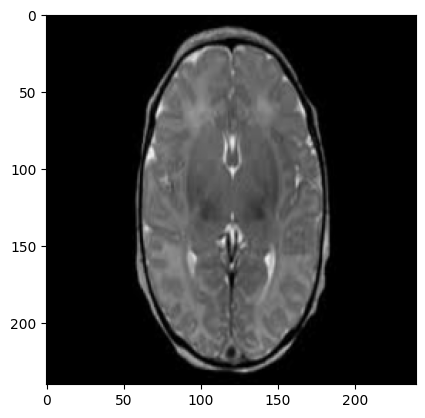

In [ ]:
# squeeze -> removes extra dimension
image = np.squeeze(test_img)
plt.imshow(image)

In [ ]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()

# Reshape the input array
nsamples, nx, ny, color = X_train.shape
X_train = X_train.reshape((nsamples, nx * ny * color))

# Fit the classifier
classifier.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [ ]:
X_train.shape


(1652, 172800)

In [ ]:
nsamples,_,_,_ = X_test.shape


In [ ]:
y_pred = classifier.predict(X_test.reshape((nsamples,-1)))


In [ ]:
# Making confusion matrix
from sklearn.metrics import confusion_matrix
#shows the number of samples that were correctly classified and misclassified for each class. The rows represent the true labels, and the columns represent the predicted labels
cm = confusion_matrix(y_test,y_pred)
cm

array([[38,  5],
       [18, 21]])

In [ ]:
from sklearn import metrics
#calculates the accuracy of the classifier predictions
#percentage of correctly predicted samples out of the total number of samples in the test set.
prediction = metrics.accuracy_score(y_test,y_pred)
print("Accuracy : " , prediction * 100 , "%")


Accuracy :  71.95121951219512 %
